<h1><center>Data Driven Wheel</center></h1>

# Notebook Contents

## 1) Importing Libraries

## 2) Fetching Data

## 3) Functions

## 4) Data Cleaning
### 4.1) Dealing with missing values

## 5) Outlier Analysis
### 5.1) Dealing with Outliers

## 6) A/B Testing

## 7) Exploratory Data Analysis
### 7.1) Numerical Data Visualization
### 7.2) Categorical Data Visualization

## 8) Dimension Reduction
### 8.1) Categorical Encoding
### 8.2) Data Normalization
### 8.3) Feature Selection
### 8.4) Principal Component Analysis

## 9) Data Modeling

# -------------------------------------------------------------------------------------------

# 1) Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore as sz
from scipy.stats import ttest_ind

## Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as ms

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Data Modeling Libraries
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score,r2_score, mean_absolute_error, explained_variance_score

# 2) Fetching Data

In [3]:
df_autos = pd.read_csv("autos.csv")
df_autos.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


# 3) *Functions*

In [4]:
def data_analysis(df):
    """This function performs basic data analysis."""
    
    ## Rows and columns
    print('Total Rows:', df.shape[0]);
    print('Total Columns:', df.shape[1], '\n');
    
    ## Column names
    print('Column Names:', '\n', df.columns, '\n')
    
    ## Column types
    print('Column Types:', '\n', df.dtypes)

In [5]:
def col_names_replace(df):
    """This function changes the name of columns for better readability."""
    
    df.rename(columns={'yearOfRegistration':'Registration_Year', 'powerPS':'HorsePower',
                       'monthOfRegistration':'Registration_Month', 
                       'notRepairedDamage':'NotRepaired/Damaged','price':'Price', 'seller':'Seller'}, inplace=True)

In [6]:
def fill_missing(df):
    """This column fills the missing values in categorical columns with 'Unknown'."""
    
    df['vehicleType'].fillna("Unknown", inplace=True);
    df['gearbox'].fillna("Unknown", inplace=True);
    df['model'].fillna("Unknown", inplace=True);
    df['fuelType'].fillna("Unknown", inplace=True);
    df['NotRepaired/Damaged'].fillna("Unknown", inplace=True);

In [7]:
def capitalize_letters(df_col_obs):
    """This function capitalizes the first letter of each observation in the respective column."""
    
    cap_words = df_col_obs[0].upper()+df_col_obs[1:];
    return cap_words

In [8]:
def obs_mapping(df):
    """This function translates and maps German words to English words."""
    
    df['Seller'] = df['Seller'].replace({'privat': 'Private', 'gewerblich': 'Commercial'});
    df['offerType'] = df['offerType'].replace({'Angebot': 'Customer Offer', 'Gesuch': 'Company Offer'});
    df['gearbox'] = df['gearbox'].replace({'manuell': 'Manual', 'automatik': 'Automatic'});
    df['vehicleType'] = df['vehicleType'].replace({'limousine': 'Limousine', 'kleinwagen': 'Compact Car',
                                               'kombi':'Station Wagon', 'bus':'Bus', 'cabrio': 'Convertible', 
                                               'coupe': 'Coupe', 'suv': 'SUV', 'andere': 'Other'});
    
    df['model'] = df['model'].replace({'golf': 'Golf', 'e_klasse': 'E-Class','3er':'3-series', 
                                   'polo': 'Polo', 'a4': 'A4', 'corsa':'Corsa', 
                                   'astra':'Astra', 'passat': 'Passat', 'a3': 'A3',
                                   'c_klasse': 'C-Class','5er': '5-Series', 'andere': 'Other',
                                   'a6': 'A6', 'focus': 'Focus', 'fiesta': 'Fiesta',
                                   'twingo': 'Twingo'});
    
    df['fuelType'] = df['fuelType'].replace({'benzin':'Gasoline', 'diesel':'Diesel', 'lpg':'LPG', 
                                                     'cng':'CNG', 'hybrid':'Hybrid', 'andere':'Other', 
                                                     'elektro':'Electric'});
    
    df['NotRepaired/Damaged'] = df['NotRepaired/Damaged'].replace({'nein':'No', 'ja':'Yes'});
    
    return df

In [9]:
def var_cap(pca, var_thres):
    """This function outputs the number of principal components depending on the amount of variance threshold."""
    
    comp_cap_max_var = np.where(np.cumsum(pca.explained_variance_ratio_) >= var_thres)[0][0]+1;
    return (comp_cap_max_var)

In [10]:
data_analysis(df_autos)

Total Rows: 371528
Total Columns: 21 

Column Names: 
 Index(['index', 'dateCrawled', 'name', 'seller', 'offerType', 'price',
       'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object') 

Column Types: 
 index                   int64
dateCrawled            object
name                   object
seller                 object
offerType              object
price                   int64
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
kilometer               int64
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
dateCreated            object
nrOfPictures            int64
postalCode            

### There are more than 370k rows and 21 columns along with a mix of categorical and numerical variables in this dataset.

## 4.2) Data Wrangling

In [11]:
## Filling column with missing values with the mean of the respective column.

cols_to_impute = ['vehicleType', 'gearbox', 'model', 'fuelType', 'notRepairedDamage']

imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(df_autos[cols_to_impute])

df_autos[cols_to_impute] = imputed_data
df_autos.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,limousine,1993,manuell,...,golf,150000,0,benzin,volkswagen,nein,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,golf,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,nein,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [12]:
## Fixing column names

col_names_replace(df_autos)

In [13]:
## Capitalizing the first letter of each observation in the respective columns

df_autos['brand'] = df_autos['brand'].apply(capitalize_letters)
df_autos['abtest'] = df_autos['abtest'].apply(capitalize_letters)

In [14]:
## Mapping to English Words

df_autos = obs_mapping(df_autos)

In [15]:
## Dropping columns

cols_to_drop = ['index', 'nrOfPictures', 'postalCode'];
df_autos.drop(cols_to_drop, axis=1, inplace=True);

### Following filtering is carried out below:
### Registration_Year column filtered for Years between 1950s and 2022. 
### Price column filtered for values greater than 0 and less than 100000.
### HorsePower column filtered for values greater than 10

In [16]:
## Filtering the dataset for years between 1950 and 2022. 
## Filtering for Price range between $500 and $100000.
## Filtering for horsepower between 10 and 2000.

df_autos = df_autos[(df_autos['Registration_Year']>=1950) & (df_autos['Registration_Year']<=2022) &
                    (df_autos['Price']>=500) & (df_autos['Price']<=100000) &
                    (df_autos['HorsePower']>10) & (df_autos['HorsePower']<=2000)];
df_autos.head()

,dateCrawled,name,Seller,offerType,Price,abtest,vehicleType,Registration_Year,gearbox,HorsePower,model,kilometer,Registration_Month,fuelType,brand,NotRepaired/Damaged,dateCreated,lastSeen
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,Private,Customer Offer,18300,Test,Coupe,2011,Manual,190,Golf,125000,5,Diesel,Audi,Yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",Private,Customer Offer,9800,Test,SUV,2004,Automatic,163,grand,125000,8,Diesel,Jeep,No,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,Private,Customer Offer,1500,Test,Compact Car,2001,Manual,75,Golf,150000,6,Gasoline,Volkswagen,No,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,Private,Customer Offer,3600,Test,Compact Car,2008,Manual,69,fabia,90000,7,Diesel,Skoda,No,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,Private,Customer Offer,650,Test,Limousine,1995,Manual,102,3-series,150000,10,Gasoline,Bmw,Yes,2016-04-04 00:00:00,2016-04-06 19:17:07


In [17]:
## Feature engineering a new column using the registeration year.

df_autos['Risk_Level'] = ['High' if x >=1950 and x<=2000 else 'Medium' if x>2000 and x<=2010 else 'Low' 
                          for x in df_autos['Registration_Year']];

In [18]:
## Dropping columns

cols_to_drop = ['dateCrawled', 'name', 'dateCreated', 'lastSeen', 'Registration_Month']
df_autos.drop(cols_to_drop, axis=1, inplace=True)
df_autos.head()

,Seller,offerType,Price,abtest,vehicleType,Registration_Year,gearbox,HorsePower,model,kilometer,fuelType,brand,NotRepaired/Damaged,Risk_Level
1,Private,Customer Offer,18300,Test,Coupe,2011,Manual,190,Golf,125000,Diesel,Audi,Yes,Low
2,Private,Customer Offer,9800,Test,SUV,2004,Automatic,163,grand,125000,Diesel,Jeep,No,Medium
3,Private,Customer Offer,1500,Test,Compact Car,2001,Manual,75,Golf,150000,Gasoline,Volkswagen,No,Medium
4,Private,Customer Offer,3600,Test,Compact Car,2008,Manual,69,fabia,90000,Diesel,Skoda,No,Medium
5,Private,Customer Offer,650,Test,Limousine,1995,Manual,102,3-series,150000,Gasoline,Bmw,Yes,High


# 8) Dimension Reduction
## 8.1) Categorical Encoding

In [19]:
## Dropping columns

cols_to_drop = ['model', 'brand'];
df_autos.drop(cols_to_drop, axis=1, inplace=True)

In [20]:
df_temp_y = df_autos.copy(deep=True);
df_temp_x = df_autos.copy(deep=True);

y = df_temp_y['Price'];
X = df_temp_x[['Seller', 'offerType', 'abtest', 'vehicleType', 'gearbox','HorsePower', 'kilometer', 'fuelType', 
               'NotRepaired/Damaged','Risk_Level']]

In [21]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object'];
num_cols = [col for col in X.columns if X[col].dtype == 'int64'];

In [23]:
y

1         18300
2          9800
3          1500
4          3600
5           650
          ...  
371520     3200
371524     1199
371525     9200
371526     3400
371527    28990
Name: Price, Length: 305466, dtype: int64

In [22]:
total_cols = num_cols + cat_cols
X_temp = X[total_cols].copy()
X_temp.head()

,HorsePower,kilometer,Seller,offerType,abtest,vehicleType,gearbox,fuelType,NotRepaired/Damaged,Risk_Level
1,190,125000,Private,Customer Offer,Test,Coupe,Manual,Diesel,Yes,Low
2,163,125000,Private,Customer Offer,Test,SUV,Automatic,Diesel,No,Medium
3,75,150000,Private,Customer Offer,Test,Compact Car,Manual,Gasoline,No,Medium
4,69,90000,Private,Customer Offer,Test,Compact Car,Manual,Diesel,No,Medium
5,102,150000,Private,Customer Offer,Test,Limousine,Manual,Gasoline,Yes,High


In [47]:
## Label encoding and One Hot Encoding

cols_to_oh_encode = ['Seller', 'offerType', 'abtest', 'vehicleType', 'gearbox', 'fuelType','NotRepaired/Damaged'];

le = LabelEncoder();

X_temp['Risk_Level'] = le.fit_transform(X_temp['Risk_Level']);
df_encoded = pd.get_dummies(X_temp, columns=cols_to_oh_encode);

df_encoded

,HorsePower,kilometer,Risk_Level,Seller_Commercial,Seller_Private,offerType_Company Offer,offerType_Customer Offer,abtest_Control,abtest_Test,vehicleType_Bus,...,gearbox_Manual,fuelType_CNG,fuelType_Diesel,fuelType_Electric,fuelType_Gasoline,fuelType_Hybrid,fuelType_LPG,fuelType_Other,NotRepaired/Damaged_No,NotRepaired/Damaged_Yes
1,190,125000,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,1
2,163,125000,2,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,75,150000,2,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
4,69,90000,2,0,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
5,102,150000,0,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371520,225,150000,2,0,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1
371524,101,125000,0,0,1,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
371525,102,150000,0,0,1,0,1,0,1,1,...,1,0,1,0,0,0,0,0,1,0
371526,100,150000,2,0,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0


## 8.2) Data Normalization

In [48]:
scaler = MinMaxScaler().fit_transform(df_encoded)

df_normalized = pd.DataFrame(scaler, columns=df_encoded.columns)
df_normalized

,HorsePower,kilometer,Risk_Level,Seller_Commercial,Seller_Private,offerType_Company Offer,offerType_Customer Offer,abtest_Control,abtest_Test,vehicleType_Bus,...,gearbox_Manual,fuelType_CNG,fuelType_Diesel,fuelType_Electric,fuelType_Gasoline,fuelType_Hybrid,fuelType_LPG,fuelType_Other,NotRepaired/Damaged_No,NotRepaired/Damaged_Yes
0,0.089995,0.827586,0.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.076420,0.827586,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.032177,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.029160,0.586207,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.045752,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305461,0.107592,1.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
305462,0.045249,0.827586,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
305463,0.045752,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
305464,0.044746,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 8.3) Feature Selection

### Using SelectKBest method to identify top features based on the correlation and between each feature and the target variable.

In [49]:
ytemp = pd.DataFrame(df_temp_y.Price, columns =['Price'])

In [50]:
#df_sample = df_normalized.sample(30000)
#y_sample = ytemp.sample(30000);

In [50]:
'''topfeatures = SelectKBest(score_func=chi2).fit(df_sample, y_sample);

with open('feature_selection.pkl', 'wb') as pickle_file:
    pickle.dump(topfeatures, pickle_file);'''
    
with open('feature_selection.pkl', 'rb') as pickle_file:
    topfeatures = pickle.load(pickle_file);

df_scores = pd.DataFrame(topfeatures.scores_)
df_column_names = pd.DataFrame(df_normalized.columns)

df_top_features = pd.concat([df_column_names, df_scores], axis=1)
df_top_features.columns = ['Features','Score']; 

df_top_features['Score'] = round(df_top_features['Score'],-1)

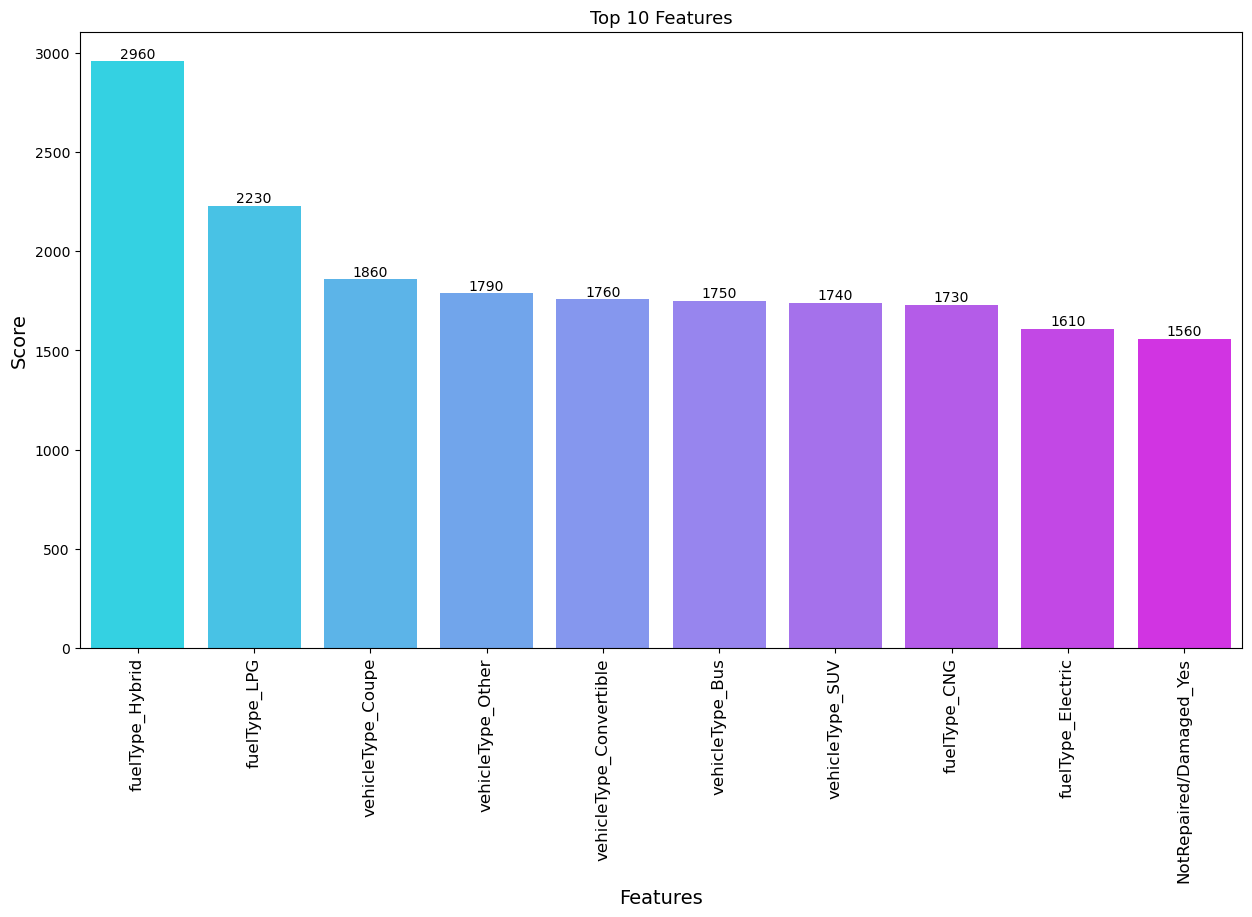

In [51]:
fig, ax = plt.subplots(figsize=(15, 8));
sns.barplot(x=df_top_features.nlargest(10,'Score').Features, y=df_top_features.nlargest(10,'Score').Score, 
            palette='cool')

ax.set_title('Top 10 Features', fontsize=13);
ax.set_xlabel('Features', fontsize=14);
ax.set_xticklabels(labels=df_top_features.nlargest(10,'Score').Features, rotation=90, fontsize=12);
ax.set_ylabel('Score', fontsize=14);
ax.bar_label(ax.containers[0]);

## 8.4) Principal Component Analysis

In [52]:
pca = PCA();

scores = pca.fit_transform(df_normalized);
df_final = pd.DataFrame(scores);

exp_var = pca.explained_variance_ratio_;
print('Explained Variance:', exp_var, '\n');

prop_var = exp_var / np.sum(exp_var)
print('Proportion Variance:',prop_var, '\n');

cum_prop_var = np.cumsum(prop_var)
print('Cummulative Proportion of Variance:', cum_prop_var)

Explained Variance: [2.08162707e-01 1.98655561e-01 1.34238124e-01 1.08940907e-01
 7.47637373e-02 6.19135702e-02 5.70750266e-02 4.53368796e-02
 2.96435645e-02 2.58061496e-02 2.32224775e-02 1.77730882e-02
 9.25283779e-03 3.36531732e-03 9.00634008e-04 3.82253191e-04
 3.26065759e-04 1.34005344e-04 9.66755234e-05 5.20940162e-06
 5.20902605e-06 1.84288471e-28 1.73272406e-28 9.50925042e-29
 1.03345492e-29 3.32090510e-30 2.51409694e-32 1.14119962e-32] 

Proportion Variance: [2.08162707e-01 1.98655561e-01 1.34238124e-01 1.08940907e-01
 7.47637373e-02 6.19135702e-02 5.70750266e-02 4.53368796e-02
 2.96435645e-02 2.58061496e-02 2.32224775e-02 1.77730882e-02
 9.25283779e-03 3.36531732e-03 9.00634008e-04 3.82253191e-04
 3.26065759e-04 1.34005344e-04 9.66755234e-05 5.20940162e-06
 5.20902605e-06 1.84288471e-28 1.73272406e-28 9.50925042e-29
 1.03345492e-29 3.32090510e-30 2.51409694e-32 1.14119962e-32] 

Cummulative Proportion of Variance: [0.20816271 0.40681827 0.54105639 0.6499973  0.72476104 0.78667

In [53]:
pca = PCA()
pca_result = pca.fit_transform(df_normalized);

df_pca_result = pd.DataFrame(pca_result);

## Finding the Principal components that capture 99% variance.
df_result = pd.DataFrame(data=pca_result, columns=[f'PC#{axis + 1}' for axis in range(28)])

PC_comp = var_cap(pca, 0.99)
PC_comp

13

In [54]:
df_dim_red = pd.DataFrame(data=pca_result[:, :PC_comp], columns=[f'PC#{axis + 1}' for axis in range(PC_comp)])
df_dim_red.index = df_normalized.index

df_dim_red.head()

,PC#1,PC#2,PC#3,PC#4,PC#5,PC#6,PC#7,PC#8,PC#9,PC#10,PC#11,PC#12,PC#13
0,0.612221,-0.689696,-0.586958,-0.187522,0.376664,0.620937,1.107069,0.392819,0.376003,-0.183551,0.898910,-0.406083,-0.029609
1,1.365011,-0.705951,0.500644,0.429445,-0.347530,0.238829,-0.082871,0.158387,0.222705,-0.157969,0.244917,0.827414,-0.088523
2,-0.625279,-0.670639,-0.407816,0.514880,-0.569689,0.020784,0.046184,-0.290757,-0.216074,-0.191907,-0.019144,0.020544,-0.011969
3,0.534453,-0.689208,-0.853025,0.238946,-0.672197,0.506431,-0.068120,-0.386040,0.236681,0.040635,0.001100,-0.132465,-0.004332
4,-0.714733,-0.669578,0.268863,-0.776391,0.581877,0.360544,1.154916,0.016841,0.040173,-0.004393,-0.023060,0.031790,-0.031919


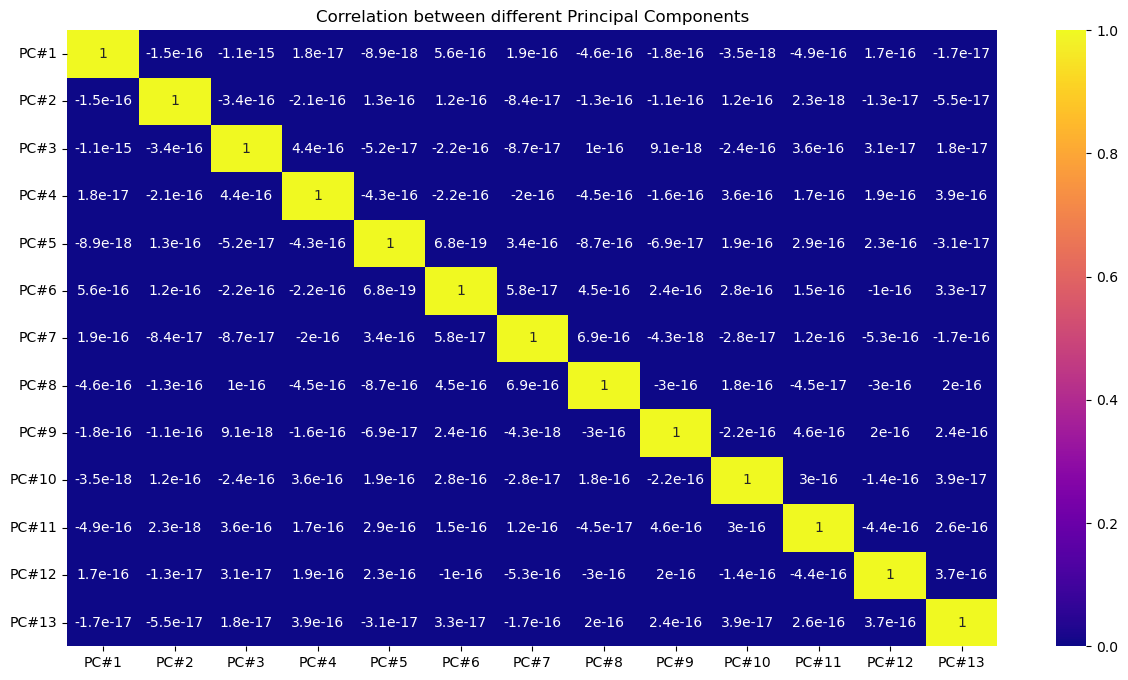

In [55]:
plt.figure(figsize=(15,8));

corr_matrix = df_dim_red.corr()
corr_features = corr_matrix.index

sns.heatmap(df_dim_red[corr_features].corr(), annot=True, cmap = 'plasma');
plt.title('Correlation between different Principal Components');

### Heatmap shows that the PC components are uncorrelated with each other

# 9) Data Modeling

In [56]:
X1 = df_dim_red.copy(deep=True);

In [57]:
## Splitting dataset into training, validation and test sets.

X_train, X_res, y_train, y_res = train_test_split(X1,y, train_size=0.7, random_state=13)
X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=13)

print("X_train.shape:", X_train.shape) 
print("y_train.shape:", y_train.shape, '\n')
print("X_valid.shape:", X_valid.shape)
print("y_valid.shape:", y_valid.shape, '\n')
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_test.shape)

X_train.shape: (213826, 13)
y_train.shape: (213826,) 

X_valid.shape: (45820, 13)
y_valid.shape: (45820,) 

X_test.shape: (45820, 13)
y_train.shape: (45820,)


## Linear Regression

In [58]:
## Training Linear Regression

lr_model = LinearRegression().fit(X_train, y_train);

lr_model_train_pred = lr_model.predict(X_train);
lr_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, lr_model_train_pred)),0);
lr_model_R2_train_ = round(r2_score(y_train, lr_model_train_pred),2);
lr_model_mae_train_ = round(mean_absolute_error(y_train, lr_model_train_pred),0);

lr_model_valid_pred = lr_model.predict(X_valid);
lr_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, lr_model_valid_pred)),0);
lr_model_R2_valid_ = round(r2_score(y_valid, lr_model_valid_pred),2);
lr_model_mae_valid_ = round(mean_absolute_error(y_valid, lr_model_valid_pred),0);

print('Training Set Metrics:')
print('MAE: ', lr_model_mae_train_);
print('RMSE:', lr_model_RMSE_train_);
print('R2:  ', lr_model_R2_train_, '\n');

print('Validation Set Metrics:')
print('MAE: ', lr_model_mae_valid_);
print('RMSE:', lr_model_RMSE_valid_);
print('R2:  ', lr_model_R2_valid_);

Training Set Metrics:
MAE:  3615.0
RMSE: 5923.0
R2:   0.42 

Validation Set Metrics:
MAE:  3607.0
RMSE: 5911.0
R2:   0.42


## Elastic Net

In [59]:
## Training Elastic Net

E_net = ElasticNet().fit(X_train, y_train);

Enet_model_train_pred = E_net.predict(X_train);
Enet_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, Enet_model_train_pred)),0);
Enet_model_R2_train_ = round(r2_score(y_train, Enet_model_train_pred),2)
Enet_model_mae_train_ = round(mean_absolute_error(y_train, Enet_model_train_pred),0);

Enet_model_valid_pred = E_net.predict(X_valid);
Enet_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, Enet_model_valid_pred)),0);
Enet_model_R2_valid_ = round(r2_score(y_valid, Enet_model_valid_pred),2)
Enet_model_mae_valid_ = round(mean_absolute_error(y_valid, Enet_model_valid_pred),0);

print('Training Set Metrics:')
print('MAE: ', Enet_model_mae_train_);
print('RMSE:', Enet_model_RMSE_train_);
print('R2:  ', Enet_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', Enet_model_mae_valid_);
print('RMSE:', Enet_model_RMSE_valid_);
print('R2:  ', Enet_model_R2_valid_);

Training Set Metrics:
MAE:  4502.0
RMSE: 7053.0
R2:   0.18 

Validation Set Metrics:
MAE:  4514.0
RMSE: 7042.0
R2:   0.18


## Decision Tree Regressor

In [60]:
## Training Decision Tree Regressor

dt_model = DecisionTreeRegressor().fit(X_train, y_train);

dt_model_train_pred = dt_model.predict(X_train);
dt_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, dt_model_train_pred)),0);
dt_model_R2_train_ = round(r2_score(y_train, dt_model_train_pred),2)
dt_model_mae_train_ = round(mean_absolute_error(y_train, dt_model_train_pred),0);

dt_model_valid_pred = dt_model.predict(X_valid);
dt_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, dt_model_valid_pred)),0);
dt_model_R2_valid_ = round(r2_score(y_valid, dt_model_valid_pred),2)
dt_model_mae_valid_ = round(mean_absolute_error(y_valid, dt_model_valid_pred),0);

print('Training Set Metrics:');
print('MAE: ', dt_model_mae_train_);
print('RMSE:', dt_model_RMSE_train_);
print('R2:  ', dt_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', dt_model_mae_valid_);
print('RMSE:', dt_model_RMSE_valid_);
print('R2:  ', dt_model_R2_valid_);

Training Set Metrics:
MAE:  1269.0
RMSE: 2309.0
R2:   0.91 

Validation Set Metrics:
MAE:  2075.0
RMSE: 4363.0
R2:   0.68


## Gradient Boosting Regressor

In [62]:
'''
## Training Gradient Boosting Regressor
gbr = GradientBoostingRegressor().fit(X_train, y_train);

gbr_model_train_pred = gbr.predict(X_train);
gbr_model_valid_pred = gbr.predict(X_valid);'''

'\n## Training Gradient Boosting Regressor\ngbr = GradientBoostingRegressor().fit(X_train, y_train);\n\ngbr_model_train_pred = gbr.predict(X_train);\ngbr_model_valid_pred = gbr.predict(X_valid);'

In [63]:
'''
## Saving the model trained using pickle
with open('gbr_train.pkl', 'wb') as pickle_file:
    pickle.dump(gbr_model_train_pred, pickle_file);
    
with open('gbr_valid.pkl', 'wb') as pickle_file:
    pickle.dump(gbr_model_valid_pred, pickle_file);'''

"\n## Saving the model trained using pickle\nwith open('gbr_train.pkl', 'wb') as pickle_file:\n    pickle.dump(gbr_model_train_pred, pickle_file);\n    \nwith open('gbr_valid.pkl', 'wb') as pickle_file:\n    pickle.dump(gbr_model_valid_pred, pickle_file);"

In [64]:
## Loading the pickle file

with open('gbr_train.pkl', 'rb') as pickle_file:
    gbr_train_pred = pickle.load(pickle_file);
with open('gbr_valid.pkl', 'rb') as pickle_file:
    gbr_valid_pred = pickle.load(pickle_file)

In [65]:
gbr_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, gbr_train_pred)),0);
gbr_model_R2_train_ = round(r2_score(y_train, gbr_train_pred),2)
gbr_model_mae_train_ = round(mean_absolute_error(y_train, gbr_train_pred),0);

gbr_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, gbr_valid_pred)),0);
gbr_model_R2_valid_ = round(r2_score(y_valid, gbr_valid_pred),2)
gbr_model_mae_valid_ = round(mean_absolute_error(y_valid, gbr_valid_pred),0);

print('Training Set Metrics:');
print('MAE: ', gbr_model_mae_train_);
print('RMSE:', gbr_model_RMSE_train_);
print('R2:  ', gbr_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', gbr_model_mae_valid_);
print('RMSE:', gbr_model_RMSE_valid_);
print('R2:  ', gbr_model_R2_valid_);

Training Set Metrics:
MAE:  2955.0
RMSE: 5253.0
R2:   0.54 

Validation Set Metrics:
MAE:  2965.0
RMSE: 5281.0
R2:   0.54


## XG Boosting

In [66]:
'''
## Training XG Boosting
xgb_model = xgb.XGBRegressor().fit(X_train, y_train);

xgb_model_train_pred = xgb_model.predict(X_train);
xgb_model_valid_pred = xgb_model.predict(X_valid);'''

'\n## Training XG Boosting\nxgb_model = xgb.XGBRegressor().fit(X_train, y_train);\n\nxgb_model_train_pred = xgb_model.predict(X_train);\nxgb_model_valid_pred = xgb_model.predict(X_valid);'

In [67]:
'''
## Saving the model trained using pickle
with open('xgb_train.pkl', 'wb') as pickle_file:
    pickle.dump(xgb_model_train_pred, pickle_file);
    
with open('xgb_valid.pkl', 'wb') as pickle_file:
    pickle.dump(xgb_model_valid_pred, pickle_file);'''

"\n## Saving the model trained using pickle\nwith open('xgb_train.pkl', 'wb') as pickle_file:\n    pickle.dump(xgb_model_train_pred, pickle_file);\n    \nwith open('xgb_valid.pkl', 'wb') as pickle_file:\n    pickle.dump(xgb_model_valid_pred, pickle_file);"

In [68]:
## Loading the pickle file

with open('xgb_train.pkl', 'rb') as pickle_file:
    xgb_train_pred = pickle.load(pickle_file);
with open('xgb_valid.pkl', 'rb') as pickle_file:
    xgb_valid_pred = pickle.load(pickle_file)

In [69]:
xgb_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, xgb_train_pred)),0);
xgb_model_R2_train_ = round(r2_score(y_train, xgb_train_pred),2)
xgb_model_mae_train_ = round(mean_absolute_error(y_train, xgb_train_pred),0);


xgb_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, xgb_valid_pred)),0);
xgb_model_R2_valid_ = round(r2_score(y_valid, xgb_valid_pred),2)
xgb_model_mae_valid_ = round(mean_absolute_error(y_valid, xgb_valid_pred),0);

print('Training Set Metrics:');
print('MAE: ', xgb_model_mae_train_);
print('RMSE:', xgb_model_RMSE_train_);
print('R2:  ', xgb_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', xgb_model_mae_valid_);
print('RMSE:', xgb_model_RMSE_valid_);
print('R2:  ', xgb_model_R2_valid_);

Training Set Metrics:
MAE:  2335.0
RMSE: 4045.0
R2:   0.73 

Validation Set Metrics:
MAE:  2446.0
RMSE: 4423.0
R2:   0.68


## Random Forest Regressor

In [70]:
'''
## Training Random Forest Regressor
rf_model = RandomForestRegressor().fit(X_train, y_train);

rf_model_train_pred = rf_model.predict(X_train);
rf_model_valid_pred = rf_model.predict(X_valid);'''

'\n## Training Random Forest Regressor\nrf_model = RandomForestRegressor().fit(X_train, y_train);\n\nrf_model_train_pred = rf_model.predict(X_train);\nrf_model_valid_pred = rf_model.predict(X_valid);'

In [71]:
'''
## Saving the model trained using pickle
with open('rf_train.pkl', 'wb') as pickle_file:
    pickle.dump(rf_model_train_pred, pickle_file);
    
with open('rf_valid.pkl', 'wb') as pickle_file:
    pickle.dump(rf_model_valid_pred, pickle_file);'''

"\n## Saving the model trained using pickle\nwith open('rf_train.pkl', 'wb') as pickle_file:\n    pickle.dump(rf_model_train_pred, pickle_file);\n    \nwith open('rf_valid.pkl', 'wb') as pickle_file:\n    pickle.dump(rf_model_valid_pred, pickle_file);"

In [72]:
## Loading the pickle file

with open('rf_train.pkl', 'rb') as pickle_file:
    rf_train_pred = pickle.load(pickle_file);
with open('rf_valid.pkl', 'rb') as pickle_file:
    rf_valid_pred = pickle.load(pickle_file)

In [73]:
rf_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, rf_train_pred)),0);
rf_model_R2_train_ = round(r2_score(y_train, rf_train_pred),2)
rf_model_mae_train_ = round(mean_absolute_error(y_train, rf_train_pred),0);

rf_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, rf_valid_pred)),0);
rf_model_R2_valid_ = round(r2_score(y_valid, rf_valid_pred),2)
rf_model_mae_valid_ = round(mean_absolute_error(y_valid, rf_valid_pred),0);

print('Training Set Metrics:');
print('MAE: ', rf_model_mae_train_);
print('RMSE:', rf_model_RMSE_train_);
print('R2:  ', rf_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', rf_model_mae_valid_);
print('RMSE:', rf_model_RMSE_valid_);
print('R2:  ', rf_model_R2_valid_);

Training Set Metrics:
MAE:  1470.0
RMSE: 2538.0
R2:   0.89 

Validation Set Metrics:
MAE:  2006.0
RMSE: 3977.0
R2:   0.74


In [74]:
R2_dict_train = {'Elastic Net': Enet_model_R2_train_, 'Linear Regression': lr_model_R2_train_, 
           'Gradient Boosting Regressor': gbr_model_R2_train_, 'XG Boosting': xgb_model_R2_train_,
           'Decision Tree Regressor': dt_model_R2_train_, 'Random Forest Regressor': rf_model_R2_train_};

RMSE_dict_train = {'Linear Regression': lr_model_RMSE_train_, 'Elastic Net': Enet_model_RMSE_train_, 
           'Decision Tree Regressor': dt_model_RMSE_train_, 'Gradient Boosting Regressor': gbr_model_RMSE_train_,
           'XG Boosting': xgb_model_RMSE_train_, 'Random Forest Regressor': rf_model_RMSE_train_};

MAE_dict_train = {'Linear Regression': lr_model_mae_train_, 'Elastic Net': Enet_model_mae_train_, 
           'Decision Tree Regressor': dt_model_mae_train_, 'Gradient Boosting Regressor': gbr_model_mae_train_,
           'XG Boosting': xgb_model_mae_train_, 'Random Forest Regressor': rf_model_mae_train_};

In [75]:
df_R2_train = pd.DataFrame({'Model':R2_dict_train.keys(), 'R2': R2_dict_train.values()});
df_R2_train = df_R2_train.groupby(['Model'], as_index=False)['R2'].sum().sort_values('R2', ascending=False);

df_RMSE_train = pd.DataFrame({'Model':RMSE_dict_train.keys(), 'RMSE': RMSE_dict_train.values()});
df_RMSE_train = df_RMSE_train.groupby(['Model'], as_index=False)['RMSE'].sum().sort_values('RMSE', ascending=False);

df_MAE_train = pd.DataFrame({'Model':MAE_dict_train.keys(), 'MAE': MAE_dict_train.values()});
df_MAE_train = df_MAE_train.groupby(['Model'], as_index=False)['MAE'].sum().sort_values('MAE', ascending=False);

In [76]:
df_merge = pd.merge(df_R2_train, df_RMSE_train, on='Model', how='inner');
df_train_final = pd.merge(df_merge, df_MAE_train, on='Model', how='inner');
df_train_final

,Model,R2,RMSE,MAE
0,Decision Tree Regressor,0.91,2309.0,1269.0
1,Random Forest Regressor,0.89,2538.0,1470.0
2,XG Boosting,0.73,4045.0,2335.0
3,Gradient Boosting Regressor,0.54,5253.0,2955.0
4,Linear Regression,0.42,5923.0,3615.0
5,Elastic Net,0.18,7053.0,4502.0


In [77]:
R2_dict_valid = {'Elastic Net': Enet_model_R2_valid_, 'Linear Regression': lr_model_R2_valid_, 
           'Gradient Boosting Regressor': gbr_model_R2_valid_, 'XG Boosting': xgb_model_R2_valid_,
           'Decision Tree Regressor': dt_model_R2_valid_, 'Random Forest Regressor': rf_model_R2_valid_};

RMSE_dict_valid = {'Linear Regression': lr_model_RMSE_valid_, 'Elastic Net': Enet_model_RMSE_valid_, 
           'Decision Tree Regressor': dt_model_RMSE_valid_, 'Gradient Boosting Regressor': gbr_model_RMSE_valid_,
           'XG Boosting': xgb_model_RMSE_valid_, 'Random Forest Regressor': rf_model_RMSE_valid_};

MAE_dict_valid = {'Linear Regression': lr_model_mae_valid_, 'Elastic Net': Enet_model_mae_valid_, 
           'Decision Tree Regressor': dt_model_mae_valid_, 'Gradient Boosting Regressor': gbr_model_mae_valid_,
           'XG Boosting': xgb_model_mae_valid_, 'Random Forest Regressor': rf_model_mae_valid_};

In [78]:
df_R2_valid = pd.DataFrame({'Model':R2_dict_valid.keys(), 'R2': R2_dict_valid.values()});
df_R2_valid = df_R2_valid.groupby(['Model'], as_index=False)['R2'].sum().sort_values('R2', ascending=False);

df_RMSE_valid = pd.DataFrame({'Model':RMSE_dict_valid.keys(), 'RMSE': RMSE_dict_valid.values()});
df_RMSE_valid = df_RMSE_valid.groupby(['Model'], as_index=False)['RMSE'].sum().sort_values('RMSE', ascending=False);

df_MAE_valid = pd.DataFrame({'Model':MAE_dict_valid.keys(), 'MAE': MAE_dict_valid.values()});
df_MAE_valid = df_MAE_valid.groupby(['Model'], as_index=False)['MAE'].sum().sort_values('MAE', ascending=False);

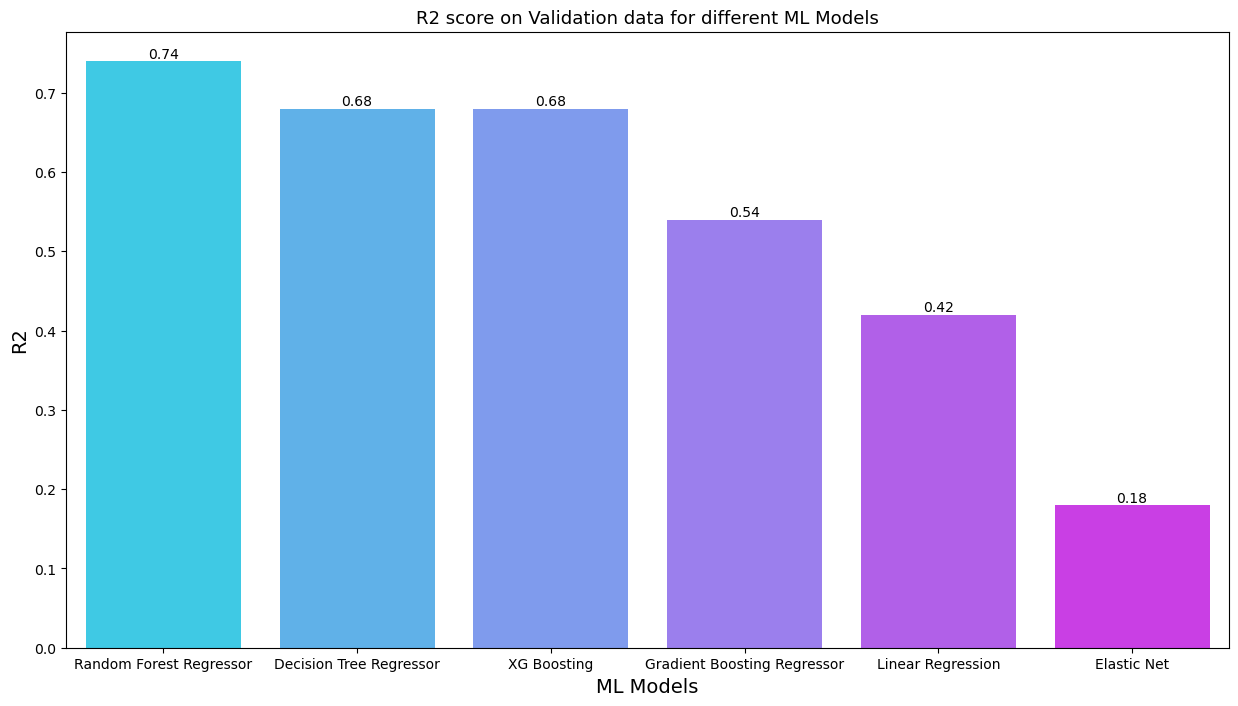

In [79]:
fig, ax = plt.subplots(figsize=(15, 8));

sns.barplot(x='Model', y='R2', data=df_R2_valid, palette = 'cool');
ax.set_title('R2 score on Validation data for different ML Models', fontsize=13);
ax.set_xlabel('ML Models', fontsize=14);
ax.set_ylabel('R2', fontsize=14);
ax.bar_label(ax.containers[0]);

### Higher values of R2 is preferred. From the bar graph, it can be seen that the Coefficient of determination or R2 value for Random Forest Regressor is the highest. Followed by Decision Tree Regressor and XG Boosting. It is the lowest for Elastic Net.

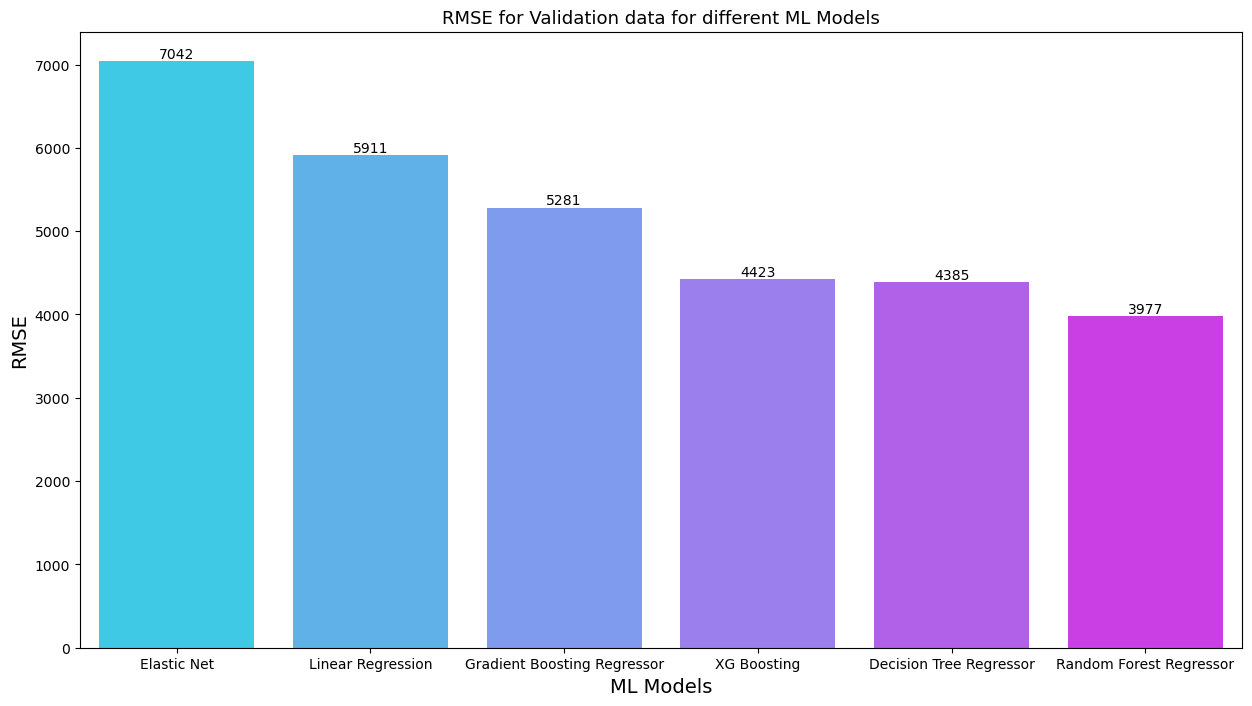

In [80]:
fig, ax = plt.subplots(figsize=(15, 8));

sns.barplot(x='Model', y='RMSE', data=df_RMSE_valid, palette = 'cool');
ax.set_title('RMSE for Validation data for different ML Models', fontsize=13);
ax.set_xlabel('ML Models', fontsize=14);
ax.set_ylabel('RMSE', fontsize=14);
ax.bar_label(ax.containers[0]);

### Lower values for RMSE is preferred. The higher the value, the worst the model performance. It can be seen that Elastic Net has the highest RMSE value. The lowest is for Random Forest Regressor.

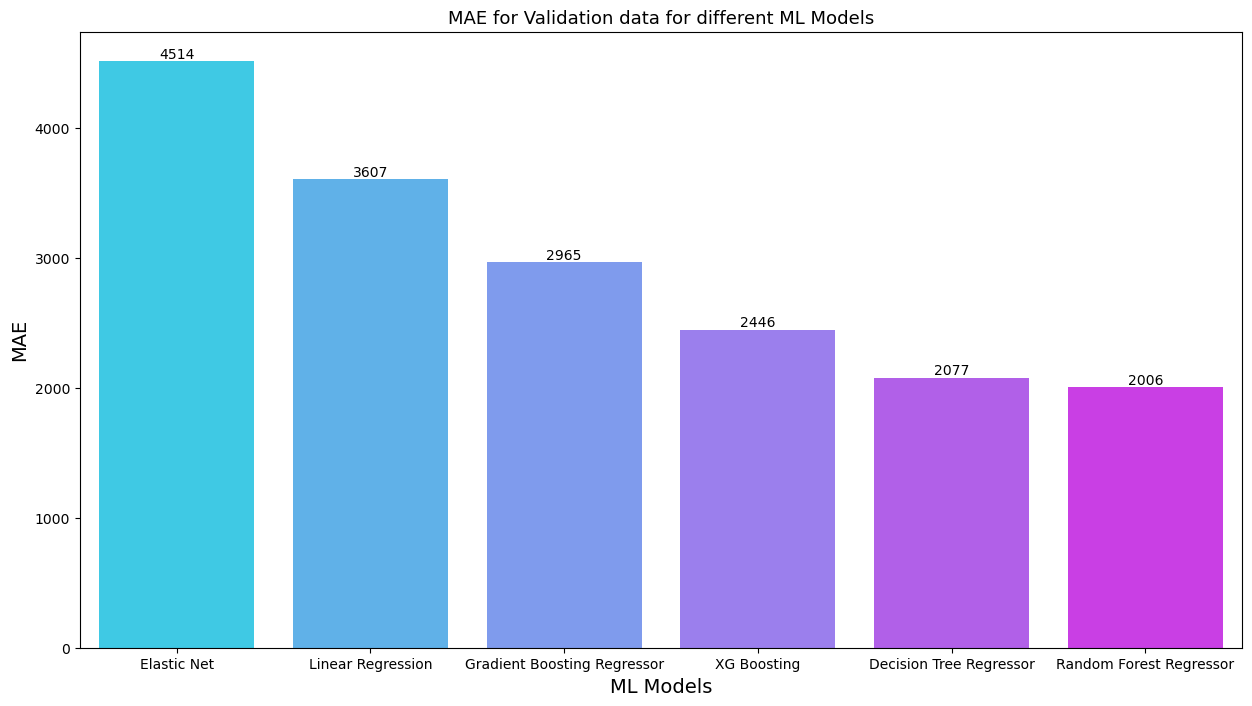

In [81]:
fig, ax = plt.subplots(figsize=(15, 8));

sns.barplot(x='Model', y='MAE', data=df_MAE_valid, palette = 'cool');
ax.set_title('MAE for Validation data for different ML Models', fontsize=13);
ax.set_xlabel('ML Models', fontsize=14);
ax.set_ylabel('MAE', fontsize=14);
ax.bar_label(ax.containers[0]);

### Lower values for Mean Absolute Error are preferred. Higher the values of MAE suggest that there is vast difference between output variable and predicted output variable. Elastic Net has the highest value. Random Forest Regressor performed the best as it has the lowest MAE.

## Hyperparameter Tuning

In [82]:
## Training Elastic Net by tuning hyperparameters

E_net = ElasticNet();

parameters = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 1000, 10000],
    'tol': [0.0001, 0.001, 0.01, 0.1]
}

rs_Enet = RandomizedSearchCV(E_net, parameters, random_state=13).fit(X_train, y_train);

print('Best Parameters for Elastic Net: ', rs_Enet.best_params_, '\n');

Enet_model_best_est_ = rs_Enet.best_estimator_;
Enet_model_train_pred = Enet_model_best_est_.predict(X_train);
Enet_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, Enet_model_train_pred)), 0);
Enet_model_R2_train_ = round(r2_score(y_train, Enet_model_train_pred),2)
Enet_model_mae_train_ = round(mean_absolute_error(y_train, Enet_model_train_pred), 0);

Enet_model_best_est_ = rs_Enet.best_estimator_;
Enet_model_valid_pred = Enet_model_best_est_.predict(X_valid);
Enet_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, Enet_model_valid_pred)), 0);
Enet_model_R2_valid_ = round(r2_score(y_valid, Enet_model_valid_pred),2)
Enet_model_mae_valid_ = round(mean_absolute_error(y_valid, Enet_model_valid_pred), 0);

print('Training Set Metrics:');
print('MAE: ', Enet_model_mae_train_);
print('RMSE:', Enet_model_RMSE_train_);
print('R2:  ', Enet_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', Enet_model_mae_valid_);
print('RMSE:', Enet_model_RMSE_valid_);
print('R2:  ', Enet_model_R2_valid_);

Best Parameters for Elastic Net:  {'tol': 0.01, 'max_iter': 1000, 'l1_ratio': 0.3, 'alpha': 0.01} 

Training Set Metrics:
MAE:  3588.0
RMSE: 5933.0
R2:   0.42 

Validation Set Metrics:
MAE:  3578.0
RMSE: 5920.0
R2:   0.42


### Using Hyper parameter tuning, the R2 value of Elastic increased from 0.18 to 0.42.

In [83]:
## Training Decision Tree Regressor by tuning hyperparameters

dt_model = DecisionTreeRegressor()

parameters = {
    'max_depth': [None] + list(range(2, 11)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'ccp_alpha': [0, 0.01, 0.1, 0.5, 1, 5]
}

rs_dt_model = RandomizedSearchCV(dt_model, parameters, random_state=13).fit(X_train, y_train);

print('Best Parameters for Decision Tree Regressor:', rs_dt_model.best_params_, '\n');

dt_model_best_est_ = rs_dt_model.best_estimator_;
dt_model_train_pred = dt_model_best_est_.predict(X_train);
dt_model_RMSE_train_ = round(np.sqrt(mean_squared_error(y_train, dt_model_train_pred)),0);
dt_model_R2_train_ = round(r2_score(y_train, dt_model_train_pred),2)
dt_model_mae_train_ = round(mean_absolute_error(y_train, dt_model_train_pred),0);

dt_model_best_est_ = rs_dt_model.best_estimator_;
dt_model_valid_pred = dt_model_best_est_.predict(X_valid);
dt_model_RMSE_valid_ = round(np.sqrt(mean_squared_error(y_valid, dt_model_valid_pred)),0);
dt_model_R2_valid_ = round(r2_score(y_valid, dt_model_valid_pred),2)
dt_model_mae_valid_ = round(mean_absolute_error(y_valid, dt_model_valid_pred),0);

print('Training Set Metrics:');
print('MAE: ', dt_model_mae_train_);
print('RMSE:', dt_model_RMSE_train_);
print('R2:  ', dt_model_R2_train_, '\n');

print('Validation Set Metrics:');
print('MAE: ', dt_model_mae_valid_);
print('RMSE:', dt_model_RMSE_valid_);
print('R2:  ', dt_model_R2_valid_);

Best Parameters for Decision Tree Regressor: {'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'ccp_alpha': 0} 

Training Set Metrics:
MAE:  1770.0
RMSE: 3292.0
R2:   0.82 

Validation Set Metrics:
MAE:  2091.0
RMSE: 4088.0
R2:   0.72


### There was a slight increase in R2 value of Decision Tree Regressor from 0.69 to 0.72.

## From the Data Modeling, it can be concluded that Random Forest Regressor performed the best on the validation set as it has the highest R2 score and the lower RMSE and MAE values.

### Now testing Random Forest Regressor on Test data

In [84]:
'''## Training Random Forest Regressor
rf_model = RandomForestRegressor().fit(X_train, y_train);
rf_model_test_pred = rf_model.predict(X_test);'''

'## Training Random Forest Regressor\nrf_model = RandomForestRegressor().fit(X_train, y_train);\nrf_model_test_pred = rf_model.predict(X_test);'

In [85]:
'''
## Saving the model trained using pickle
with open('rf_hyp_test.pkl', 'wb') as pickle_file:
    pickle.dump(rf_model_test_pred, pickle_file);'''

"\n## Saving the model trained using pickle\nwith open('rf_hyp_test.pkl', 'wb') as pickle_file:\n    pickle.dump(rf_model_test_pred, pickle_file);"

In [86]:
## Loading the pickle file

with open('rf_hyp_test.pkl', 'rb') as pickle_file:
    rf_hyp_test_pred = pickle.load(pickle_file);

In [87]:
rf_model_RMSE_test_ = round(np.sqrt(mean_squared_error(y_test, rf_hyp_test_pred)),0);
rf_model_R2_test_ = round(r2_score(y_test, rf_hyp_test_pred),2)
rf_model_mae_test_ = round(mean_absolute_error(y_test, rf_hyp_test_pred),0);

print('MAE: ', rf_model_mae_test_);
print('RMSE:', rf_model_RMSE_test_);
print('R2:  ', rf_model_R2_test_);

MAE:  1991.0
RMSE: 3928.0
R2:   0.75


### The R2 score of Random Forest Regressor has improved by 0.01 from 0.74 to 0.75 on the test set.

In [88]:
'''import joblib
joblib.dump(rf_model, 'model.pkl');'''

with open('model.pkl', 'rb') as pickle_file:
    rf_model_final = pickle.load(pickle_file);

In [89]:
import sys

major, minor, micro = sys.version_info[:3]
print(f"Your Python version is {major}.{minor}.{micro}")

Your Python version is 3.9.13
